# Introduction

This notebook explores a sample of the NYC Taxi & Limousine Commission (TLC) 2017 Yellow Taxi trip data (via Kaggle).

**Aim:** go beyond “pretty charts” and build an analyst-style view of the business: validate the fare fields, describe demand and revenue patterns, and finish with a lightweight KPI + anomaly-monitoring workflow (by day / time / pickup zone).

### What’s in the data (high level)

Each row is a single trip with:
- pickup/drop-off timestamps (`tpep_pickup_datetime`, `tpep_dropoff_datetime`)
- trip characteristics (`trip_distance`, `passenger_count`, location IDs, rate code)
- payment and charges (`payment_type`, `fare_amount`, taxes/surcharges, `tip_amount`, `total_amount`)

**Important TLC detail:** `tip_amount` is populated for card tips; cash tips are not captured, and `total_amount` does not include cash tips.


# Data viewing

Load the CSV, inspect the shape, column names and dtypes, and preview a few rows to confirm the structure matches expectations.


In [1]:

import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from utilities.data_prep import *
from utilities.eda import *

from pathlib import Path

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)



In [2]:
df = pd.read_csv('Data/2017_Yellow_Taxi_Trip_Data.csv')

check_df(df, head=10, tail=10, detail=True)


##################### Index #####################
RangeIndex(start=0, stop=22699, step=1)
##################### Shape #####################
(22699, 18)
##################### Types #####################
Unnamed: 0                 int64
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object
##################### Head #####################
   Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0    24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:

## Notes before we start

### Quick data-quality checklist

In this sample we have ~22k trips and 18 columns. Before doing EDA, we sanity-check:

- **Timestamps:** pickup should be earlier than drop-off (negative durations indicate bad records).
- **Distances / fares:** values should be non-negative; zero-distance trips can exist but merit review.
- **Refunds / adjustments:** negative `total_amount` (and occasionally negative surcharges) can occur and should be handled as a separate “refund/void” group rather than mixed into typical trips.
- **High-cardinality IDs:** location codes can overwhelm bar charts; we summarise top values when useful and later roll them up into zone-level KPIs.


# Data cleaning

Convert the pickup and drop-off columns to `datetime` so we can derive time-based features (hour/day/month) and compute trip duration.


In [3]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

We reconcile `total_amount` against the itemised fare components and create `reconciliation_diff` as a simple quality check before analysing revenue patterns.


In [4]:
tolerance = 5 # nobody gave a tip bigger than 5
for index, row in df.iterrows():
    sum_of_columns = row['fare_amount'] + row['extra'] + row['mta_tax'] + row['tip_amount'] + \
                     row['tolls_amount'] + row['improvement_surcharge']
    assert abs(sum_of_columns - row['total_amount']) <= tolerance, f"Row {index} does not sum up correctly within tolerance"


In TLC data, `total_amount` excludes cash tips, so we **do not** attempt to infer cash tips. Any non-zero `reconciliation_diff` typically reflects rounding, refunds/adjustments, or missing components (depending on the extract).


In [5]:
itemised_cols = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge"
]

itemised_cols = [c for c in itemised_cols if c in df.columns]

df["itemised_sum"] = df[itemised_cols].sum(axis=1)

# Difference between reported total and summed components (should be ~0; useful for QC)
df["reconciliation_diff"] = (df["total_amount"] - df["itemised_sum"]).round(2)

# Clean up tiny floating-point noise
df.loc[df["reconciliation_diff"].abs() < 0.01, "reconciliation_diff"] = 0

print(f"Rows where total != sum(components): {(df['reconciliation_diff'] != 0).sum()}")

Rows where total != sum(components): 43


Next we derive calendar features (hour, day of week, month, etc.) to analyse demand and revenue patterns across time.


In [6]:

# There is an error which neccesitated this be put here again
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Create a month column
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
# Create a day column
df['day'] = df['tpep_pickup_datetime'].dt.day_name()

df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,itemised_sum,reconciliation_diff,month,day
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.00,0.00,0.50,2.76,0.00,0.30,16.56,16.56,0.00,March,Saturday
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.00,0.00,0.50,4.00,0.00,0.30,20.80,20.80,0.00,April,Tuesday
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.50,0.00,0.50,1.45,0.00,0.30,8.75,8.75,0.00,December,Friday
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.50,0.00,0.50,6.39,0.00,0.30,27.69,27.69,0.00,May,Sunday
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.50,0.50,0.50,0.00,0.00,0.30,17.80,17.80,0.00,April,Saturday


We then compute trip duration (`dropoff - pickup`) and express it in minutes for easier interpretation.


In [7]:
# Calculating trip duration in time delta (difference between dropoff and pickup)
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

# Convert trip duration to minutes for easier interpretation
df['trip_duration_minutes'] = df['trip_duration'].dt.total_seconds() / 60

df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,itemised_sum,reconciliation_diff,month,day,trip_duration,trip_duration_minutes
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.00,0.00,0.50,2.76,0.00,0.30,16.56,16.56,0.00,March,Saturday,0 days 00:14:04,14.07
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.00,0.00,0.50,4.00,0.00,0.30,20.80,20.80,0.00,April,Tuesday,0 days 00:26:30,26.50
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.50,0.00,0.50,1.45,0.00,0.30,8.75,8.75,0.00,December,Friday,0 days 00:07:12,7.20
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.50,0.00,0.50,6.39,0.00,0.30,27.69,27.69,0.00,May,Sunday,0 days 00:30:15,30.25
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.50,0.50,0.50,0.00,0.00,0.30,17.80,17.80,0.00,April,Saturday,0 days 00:16:43,16.72


# Exploratory data analysis

The EDA follows a simple rhythm:

1. Split variables into categorical vs numerical (treating high-cardinality IDs separately).
2. Summarise distributions (centre, spread, skew) and look for obvious data issues.
3. Explore relationships that matter for value (distance/duration ↔ `total_amount`, payment type ↔ tips).
4. Flag outliers/refunds explicitly so they don’t distort the “typical trip” picture.


In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

Observations: 22699
Variables: 24
cat_cols: 11
num_cols: 13
cat_but_car: 0
num_but_cat: 8


In [9]:
print(cat_cols)

['store_and_fwd_flag', 'month', 'day', 'VendorID', 'passenger_count', 'RatecodeID', 'payment_type', 'extra', 'mta_tax', 'improvement_surcharge', 'reconciliation_diff']


We use `grab_col_names` to classify columns. A few integer-coded fields (e.g. `passenger_count` and some surcharge columns) behave more like numerical variables for analysis, so we include them with the numeric set where appropriate.


In [10]:
print(num_cols)

['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'itemised_sum', 'trip_duration', 'trip_duration_minutes']


In [11]:
move_cols = ['passenger_count', 'extra', 'mta_tax', 'improvement_surcharge']
num_cols.extend(move_cols)
# Items we want to remove from num_cols
items_to_remove = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
                    'pickup_day', 'week', 'pickup_hour', 
                   'month', 'dropoff_day', 'dropoff_hour', 'trip_duration']
num_cols = [item for item in num_cols if item not in items_to_remove]
#I remove year column from categorical columns
cat_cols = [col for col in cat_cols if col not in move_cols and col !='year']

In [12]:
print(cat_but_car)

[]


High-cardinality fields (notably the location IDs) can overwhelm standard plots. We treat them as “categorical-but-cardinal”: summarise top values where helpful, then return to them later in the zone-level revenue analysis.


## Categorical variables


In [13]:
print(cat_cols)

['store_and_fwd_flag', 'month', 'day', 'VendorID', 'RatecodeID', 'payment_type', 'reconciliation_diff']


                    store_and_fwd_flag  Ratio (%)
store_and_fwd_flag                               
N                                22600      99.56
Y                                   99       0.44
##########################################


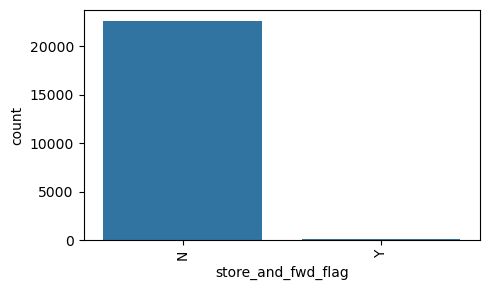

           month  Ratio (%)
month                      
March       2049       9.03
October     2027       8.93
April       2019       8.89
May         2013       8.87
January     1997       8.80
June        1964       8.65
December    1863       8.21
November    1843       8.12
February    1769       7.79
September   1734       7.64
August      1724       7.60
July        1697       7.48
##########################################


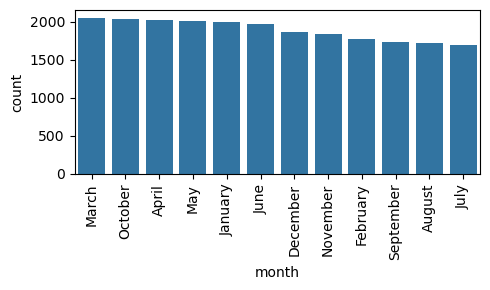

            day  Ratio (%)
day                       
Friday     3413      15.04
Thursday   3402      14.99
Wednesday  3390      14.93
Saturday   3367      14.83
Tuesday    3198      14.09
Sunday     2998      13.21
Monday     2931      12.91
##########################################


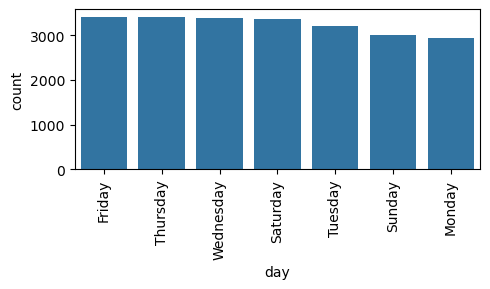

          VendorID  Ratio (%)
VendorID                     
2            12626      55.62
1            10073      44.38
##########################################


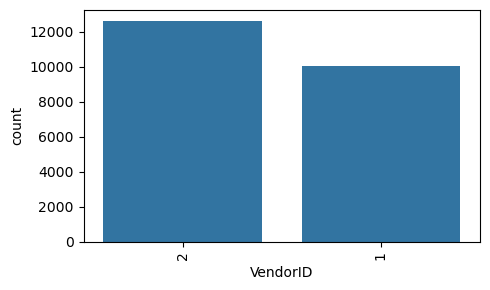

            RatecodeID  Ratio (%)
RatecodeID                       
1                22070      97.23
2                  513       2.26
5                   68       0.30
3                   39       0.17
4                    8       0.04
99                   1       0.00
##########################################


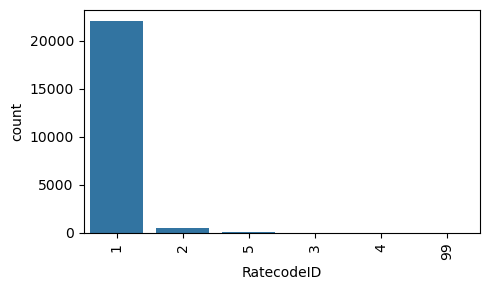

              payment_type  Ratio (%)
payment_type                         
1                    15265      67.25
2                     7267      32.01
3                      121       0.53
4                       46       0.20
##########################################


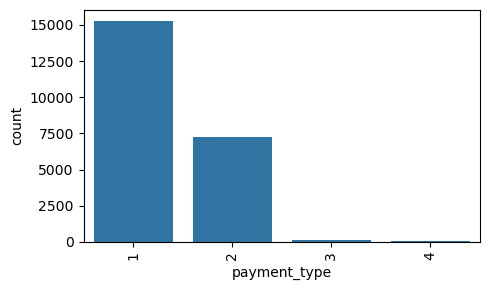

                     reconciliation_diff  Ratio (%)
reconciliation_diff                                
0.00                               22656      99.81
1.95                                  31       0.14
4.95                                  12       0.05
##########################################


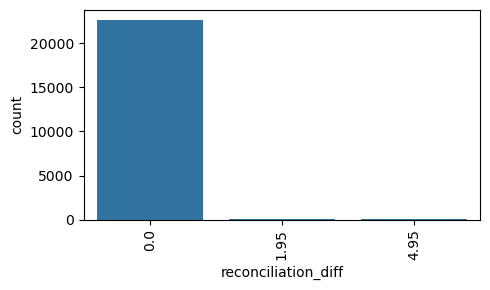

In [14]:
for col_name in cat_cols:
    cat_summary(df, col_name, plot=True)

### Key takeaways

- **Rate codes:** most trips use the standard rate; airport-related codes form a smaller but meaningful share.
- **Payment type:** card payments dominate, which aligns with `tip_amount` being populated mainly for card transactions.
- **Seasonality:** monthly volume is fairly steady with noticeable dips in late summer and in February.
- **Week pattern:** midweek to Saturday tends to be busier than Sunday/Monday in this sample.


## Numerical variables

We summarise the numerical columns with `num_summary` and visualise their distributions to understand typical trip values, skew, and potential outliers.


In [15]:
print(num_cols)

['trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'itemised_sum', 'trip_duration_minutes', 'passenger_count', 'extra', 'mta_tax', 'improvement_surcharge']


##################### trip_distance #####################
##################### Describe #####################
count   22699.00
mean        2.91
std         3.65
min         0.00
25%         0.99
50%         1.61
75%         3.06
max        33.96
Name: trip_distance, dtype: float64 

##################### Missing #####################
trip_distance NA: 0 | Total NA in df: 0


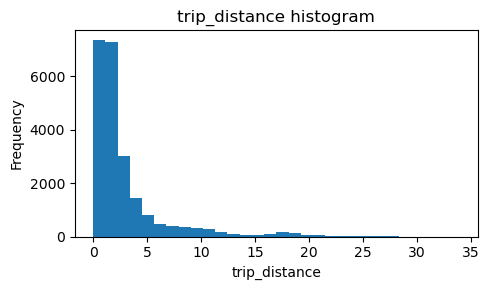

##################### PULocationID #####################
##################### Describe #####################
count   22699.00
mean      162.41
std        66.63
min         1.00
25%       114.00
50%       162.00
75%       233.00
max       265.00
Name: PULocationID, dtype: float64 

##################### Missing #####################
PULocationID NA: 0 | Total NA in df: 0


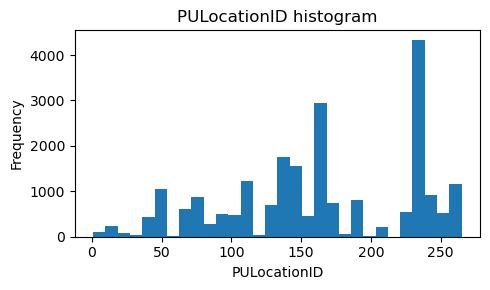

##################### DOLocationID #####################
##################### Describe #####################
count   22699.00
mean      161.53
std        70.14
min         1.00
25%       112.00
50%       162.00
75%       233.00
max       265.00
Name: DOLocationID, dtype: float64 

##################### Missing #####################
DOLocationID NA: 0 | Total NA in df: 0


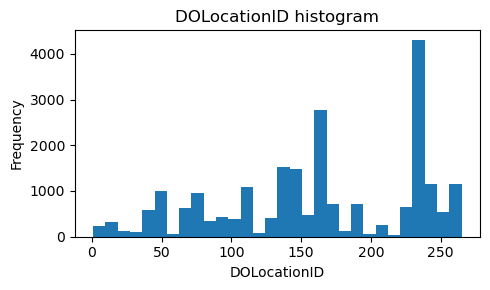

##################### fare_amount #####################
##################### Describe #####################
count   22699.00
mean       13.03
std        13.24
min      -120.00
25%         6.50
50%         9.50
75%        14.50
max       999.99
Name: fare_amount, dtype: float64 

##################### Missing #####################
fare_amount NA: 0 | Total NA in df: 0


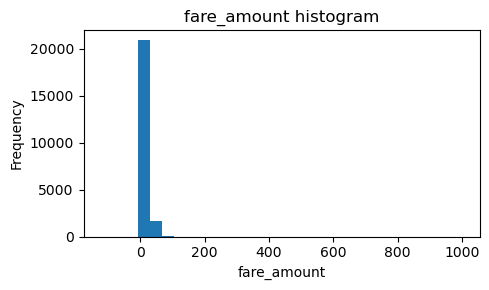

##################### tip_amount #####################
##################### Describe #####################
count   22699.00
mean        1.84
std         2.80
min         0.00
25%         0.00
50%         1.35
75%         2.45
max       200.00
Name: tip_amount, dtype: float64 

##################### Missing #####################
tip_amount NA: 0 | Total NA in df: 0


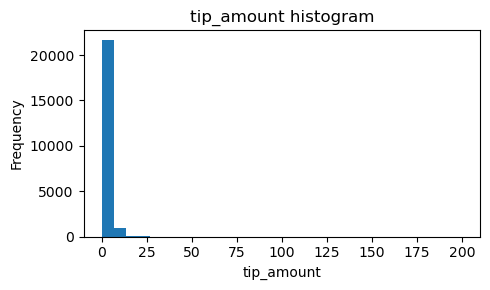

##################### tolls_amount #####################
##################### Describe #####################
count   22699.00
mean        0.31
std         1.40
min         0.00
25%         0.00
50%         0.00
75%         0.00
max        19.10
Name: tolls_amount, dtype: float64 

##################### Missing #####################
tolls_amount NA: 0 | Total NA in df: 0


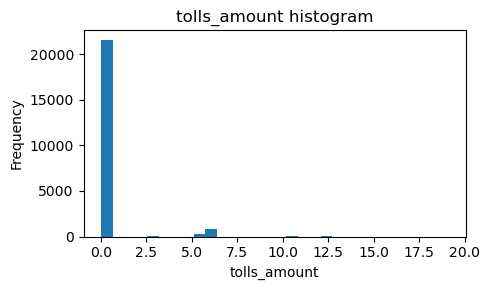

##################### total_amount #####################
##################### Describe #####################
count   22699.00
mean       16.31
std        16.10
min      -120.30
25%         8.75
50%        11.80
75%        17.80
max      1200.29
Name: total_amount, dtype: float64 

##################### Missing #####################
total_amount NA: 0 | Total NA in df: 0


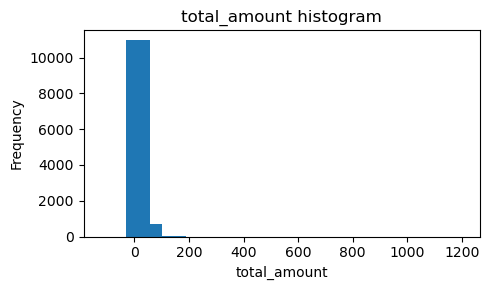

##################### itemised_sum #####################
##################### Describe #####################
count   22699.00
mean       16.31
std        16.09
min      -120.30
25%         8.75
50%        11.80
75%        17.80
max      1200.29
Name: itemised_sum, dtype: float64 

##################### Missing #####################
itemised_sum NA: 0 | Total NA in df: 0


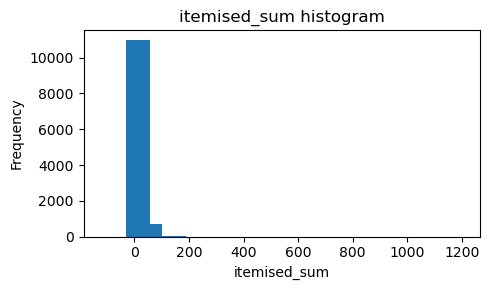

##################### trip_duration_minutes #####################
##################### Describe #####################
count   22699.00
mean       17.01
std        62.00
min       -16.98
25%         6.65
50%        11.18
75%        18.38
max      1439.55
Name: trip_duration_minutes, dtype: float64 

##################### Missing #####################
trip_duration_minutes NA: 0 | Total NA in df: 0


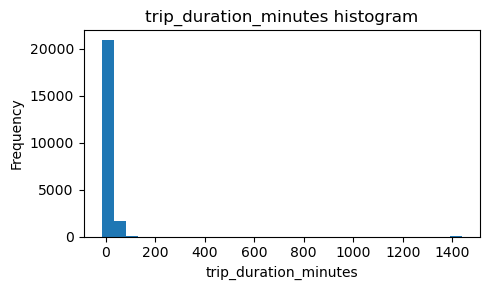

##################### passenger_count #####################
##################### Describe #####################
count   22699.00
mean        1.64
std         1.29
min         0.00
25%         1.00
50%         1.00
75%         2.00
max         6.00
Name: passenger_count, dtype: float64 

##################### Missing #####################
passenger_count NA: 0 | Total NA in df: 0


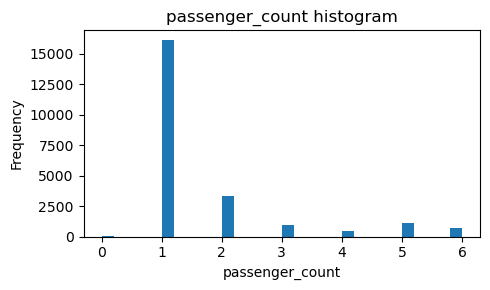

##################### extra #####################
##################### Describe #####################
count   22699.00
mean        0.33
std         0.46
min        -1.00
25%         0.00
50%         0.00
75%         0.50
max         4.50
Name: extra, dtype: float64 

##################### Missing #####################
extra NA: 0 | Total NA in df: 0


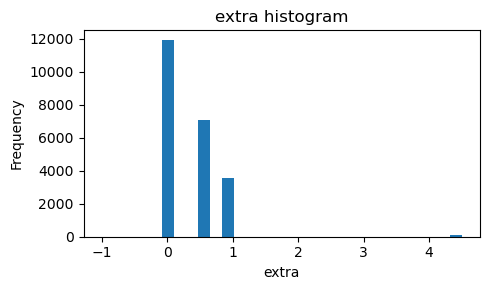

##################### mta_tax #####################
##################### Describe #####################
count   22699.00
mean        0.50
std         0.04
min        -0.50
25%         0.50
50%         0.50
75%         0.50
max         0.50
Name: mta_tax, dtype: float64 

##################### Missing #####################
mta_tax NA: 0 | Total NA in df: 0


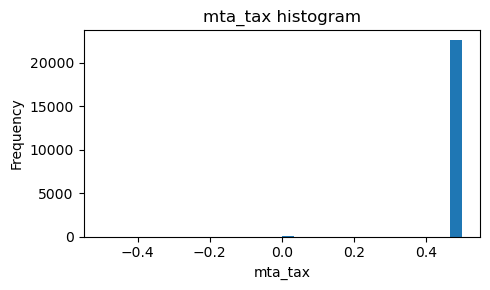

##################### improvement_surcharge #####################
##################### Describe #####################
count   22699.00
mean        0.30
std         0.02
min        -0.30
25%         0.30
50%         0.30
75%         0.30
max         0.30
Name: improvement_surcharge, dtype: float64 

##################### Missing #####################
improvement_surcharge NA: 0 | Total NA in df: 0


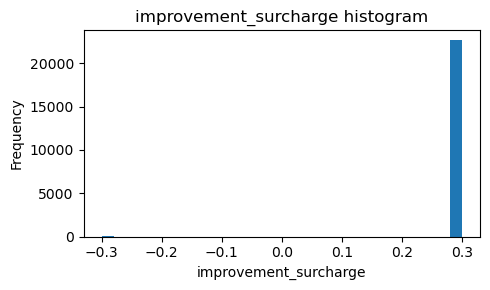

In [16]:
for col_name in num_cols:
    num_summary(df, col_name, plot=True, plot_type="hist")

### Distribution notes

- **Trip distance / duration:** strongly right-skewed; most trips are short, with a long tail of airport/long-distance rides.
- **Fares and totals:** similarly right-skewed; most totals cluster in the low-to-mid range, with occasional high-value trips.
- **Tips:** concentrated at small amounts; interpret alongside payment type (cash tips are not captured in `tip_amount`).
- **Tolls:** often zero, indicating only a subset of trips incur tolls.
- **Refunds/voids:** negative `total_amount` (and occasionally negative surcharges) represent adjustments and should be analysed separately from standard trips.


In [17]:
len(f"Number of refunds: {df[df['total_amount'] < 0]}")

6188

### Outlier analysis <a id="outliers"></a>

We use an IQR-based rule to flag extreme values. These points are not automatically “bad” (e.g., genuine long airport trips), but they are worth isolating so summary statistics aren’t driven by a small number of extreme rides.


In [18]:
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trip_distance          22699 non-null  float64
 1   PULocationID           22699 non-null  int64  
 2   DOLocationID           22699 non-null  int64  
 3   fare_amount            22699 non-null  float64
 4   tip_amount             22699 non-null  float64
 5   tolls_amount           22699 non-null  float64
 6   total_amount           22699 non-null  float64
 7   itemised_sum           22699 non-null  float64
 8   trip_duration_minutes  22699 non-null  float64
 9   passenger_count        22699 non-null  int64  
 10  extra                  22699 non-null  float64
 11  mta_tax                22699 non-null  float64
 12  improvement_surcharge  22699 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 2.3 MB


In [19]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    """
    Calculates the lower and upper thresholds for outlier detection based on quartile ranges.
    Parameters:
    - dataframe (pandas.DataFrame): The DataFrame containing the column to compute outlier thresholds.
    - col_name (str): The name of the column in the DataFrame for which to calculate outlier thresholds.
    - q1 (float, optional): The percentile value for the first quartile. Defaults to 0.25.
    - q3 (float, optional): The percentile value for the third quartile. Defaults to 0.75.

    Returns:
    - tuple: A tuple containing the lower and upper thresholds for outliers. """

    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit



def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    """
    Checks if there are any outlier values in the specified column of a DataFrame based on quantile thresholds.

    Parameters:
    - dataframe (pandas.DataFrame): The DataFrame to check for outliers.
    - col_name (str): The name of the column in which to search for outliers.
    - q1 (float, optional): The lower quantile to use for calculating the outlier detection threshold. Defaults to 0.25.
    - q3 (float, optional): The upper quantile to use for calculating the outlier detection threshold. Defaults to 0.75.

    Returns:
    - bool: True if outliers are found in the specified column; False otherwise. 
    """
    if pd.api.types.is_datetime64_any_dtype(dataframe[col_name]):
        # Handle datetime data differently or skip
        print(f"Column {col_name} is of datetime type, which is not suitable for outlier detection based on quartiles.")
        return False
    else:
        low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=q1, q3=q3)
        if (dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)] != pd.Timestamp(0)).any(axis=None):
            return True
        else:
            return False


In [20]:
# Find the outliers using the 'check_outlier' function and store them in a list.
outliers = []
for col_name in num_cols:
    result = check_outlier(df, col_name, q1=0.01, q3=0.99)
    if result == True:
        outliers.append(col_name)

outliers

['fare_amount',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'itemised_sum',
 'trip_duration_minutes',
 'extra',
 'mta_tax',
 'improvement_surcharge']

We visualise numeric columns with box plots to see spread and potential outliers at a glance.


##################### trip_distance #####################
##################### Describe #####################
count   22699.00
mean        2.91
std         3.65
min         0.00
25%         0.99
50%         1.61
75%         3.06
max        33.96
Name: trip_distance, dtype: float64 

##################### Missing #####################
trip_distance NA: 0 | Total NA in df: 0


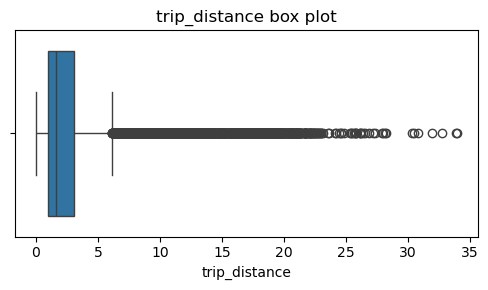

##################### PULocationID #####################
##################### Describe #####################
count   22699.00
mean      162.41
std        66.63
min         1.00
25%       114.00
50%       162.00
75%       233.00
max       265.00
Name: PULocationID, dtype: float64 

##################### Missing #####################
PULocationID NA: 0 | Total NA in df: 0


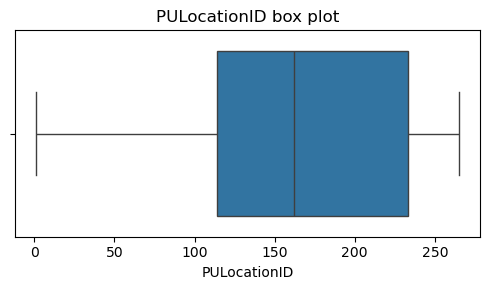

##################### DOLocationID #####################
##################### Describe #####################
count   22699.00
mean      161.53
std        70.14
min         1.00
25%       112.00
50%       162.00
75%       233.00
max       265.00
Name: DOLocationID, dtype: float64 

##################### Missing #####################
DOLocationID NA: 0 | Total NA in df: 0


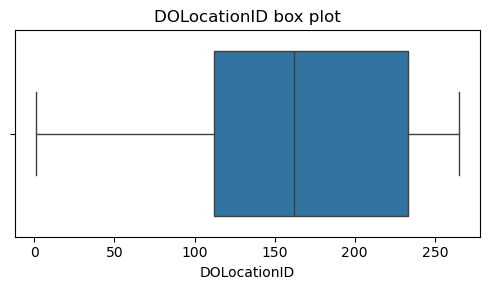

##################### fare_amount #####################
##################### Describe #####################
count   22699.00
mean       13.03
std        13.24
min      -120.00
25%         6.50
50%         9.50
75%        14.50
max       999.99
Name: fare_amount, dtype: float64 

##################### Missing #####################
fare_amount NA: 0 | Total NA in df: 0


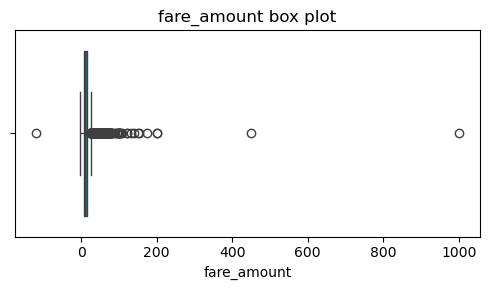

##################### tip_amount #####################
##################### Describe #####################
count   22699.00
mean        1.84
std         2.80
min         0.00
25%         0.00
50%         1.35
75%         2.45
max       200.00
Name: tip_amount, dtype: float64 

##################### Missing #####################
tip_amount NA: 0 | Total NA in df: 0


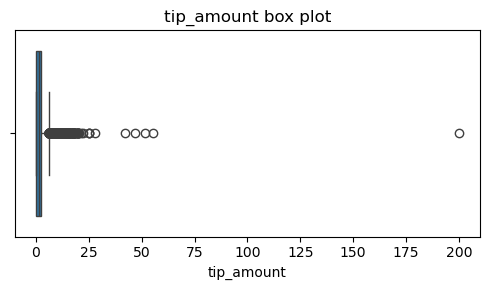

##################### tolls_amount #####################
##################### Describe #####################
count   22699.00
mean        0.31
std         1.40
min         0.00
25%         0.00
50%         0.00
75%         0.00
max        19.10
Name: tolls_amount, dtype: float64 

##################### Missing #####################
tolls_amount NA: 0 | Total NA in df: 0


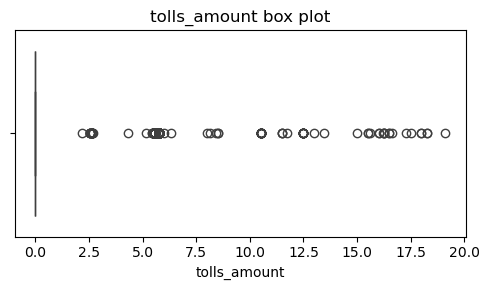

##################### total_amount #####################
##################### Describe #####################
count   22699.00
mean       16.31
std        16.10
min      -120.30
25%         8.75
50%        11.80
75%        17.80
max      1200.29
Name: total_amount, dtype: float64 

##################### Missing #####################
total_amount NA: 0 | Total NA in df: 0


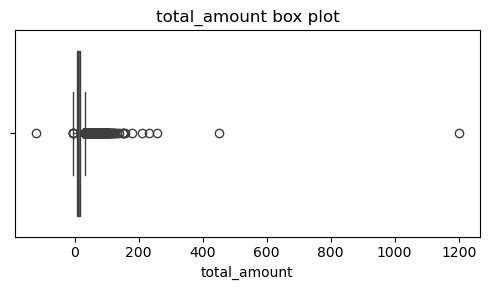

##################### itemised_sum #####################
##################### Describe #####################
count   22699.00
mean       16.31
std        16.09
min      -120.30
25%         8.75
50%        11.80
75%        17.80
max      1200.29
Name: itemised_sum, dtype: float64 

##################### Missing #####################
itemised_sum NA: 0 | Total NA in df: 0


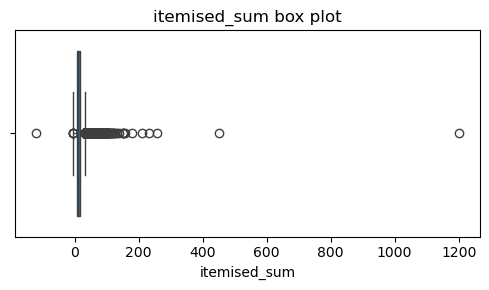

##################### trip_duration_minutes #####################
##################### Describe #####################
count   22699.00
mean       17.01
std        62.00
min       -16.98
25%         6.65
50%        11.18
75%        18.38
max      1439.55
Name: trip_duration_minutes, dtype: float64 

##################### Missing #####################
trip_duration_minutes NA: 0 | Total NA in df: 0


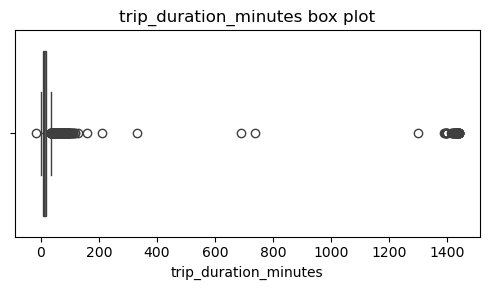

##################### passenger_count #####################
##################### Describe #####################
count   22699.00
mean        1.64
std         1.29
min         0.00
25%         1.00
50%         1.00
75%         2.00
max         6.00
Name: passenger_count, dtype: float64 

##################### Missing #####################
passenger_count NA: 0 | Total NA in df: 0


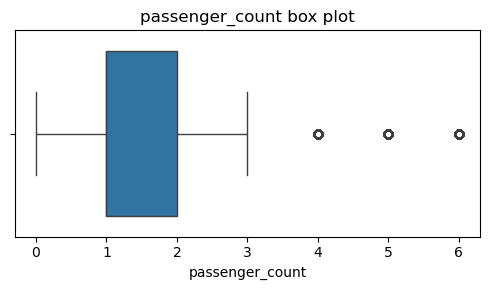

##################### extra #####################
##################### Describe #####################
count   22699.00
mean        0.33
std         0.46
min        -1.00
25%         0.00
50%         0.00
75%         0.50
max         4.50
Name: extra, dtype: float64 

##################### Missing #####################
extra NA: 0 | Total NA in df: 0


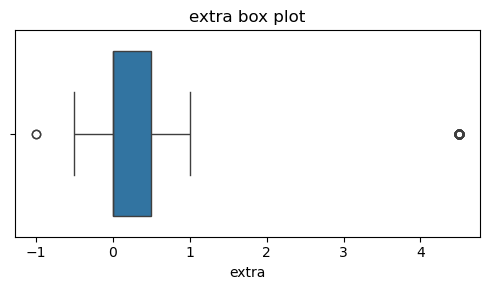

##################### mta_tax #####################
##################### Describe #####################
count   22699.00
mean        0.50
std         0.04
min        -0.50
25%         0.50
50%         0.50
75%         0.50
max         0.50
Name: mta_tax, dtype: float64 

##################### Missing #####################
mta_tax NA: 0 | Total NA in df: 0


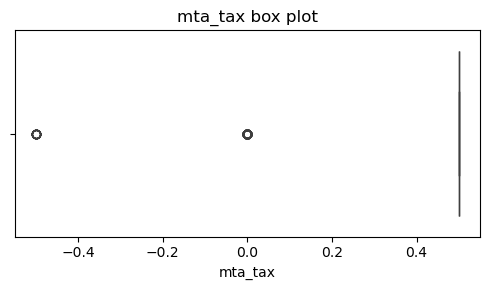

##################### improvement_surcharge #####################
##################### Describe #####################
count   22699.00
mean        0.30
std         0.02
min        -0.30
25%         0.30
50%         0.30
75%         0.30
max         0.30
Name: improvement_surcharge, dtype: float64 

##################### Missing #####################
improvement_surcharge NA: 0 | Total NA in df: 0


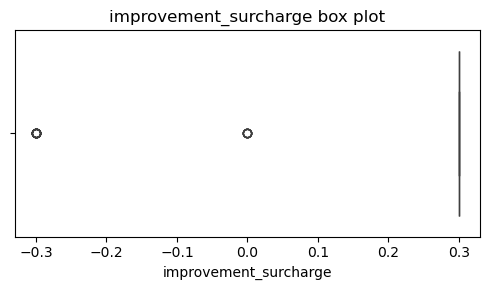

In [21]:
for col_name in num_cols:
    num_summary(df, col_name, plot=True, plot_type="box_plot")

In [22]:
cols_for_visual = [col for col in num_cols if col not in ['PULocationID', 'DOLocationID', 'reconciliation_diff', 'extra', 'mta_tax', 'improvement_surcharge']]


### Pairwise relationships between numerical variables

A quick pair plot helps check how distance, duration and charges move together, and whether there are obvious non-linearities or data artefacts.


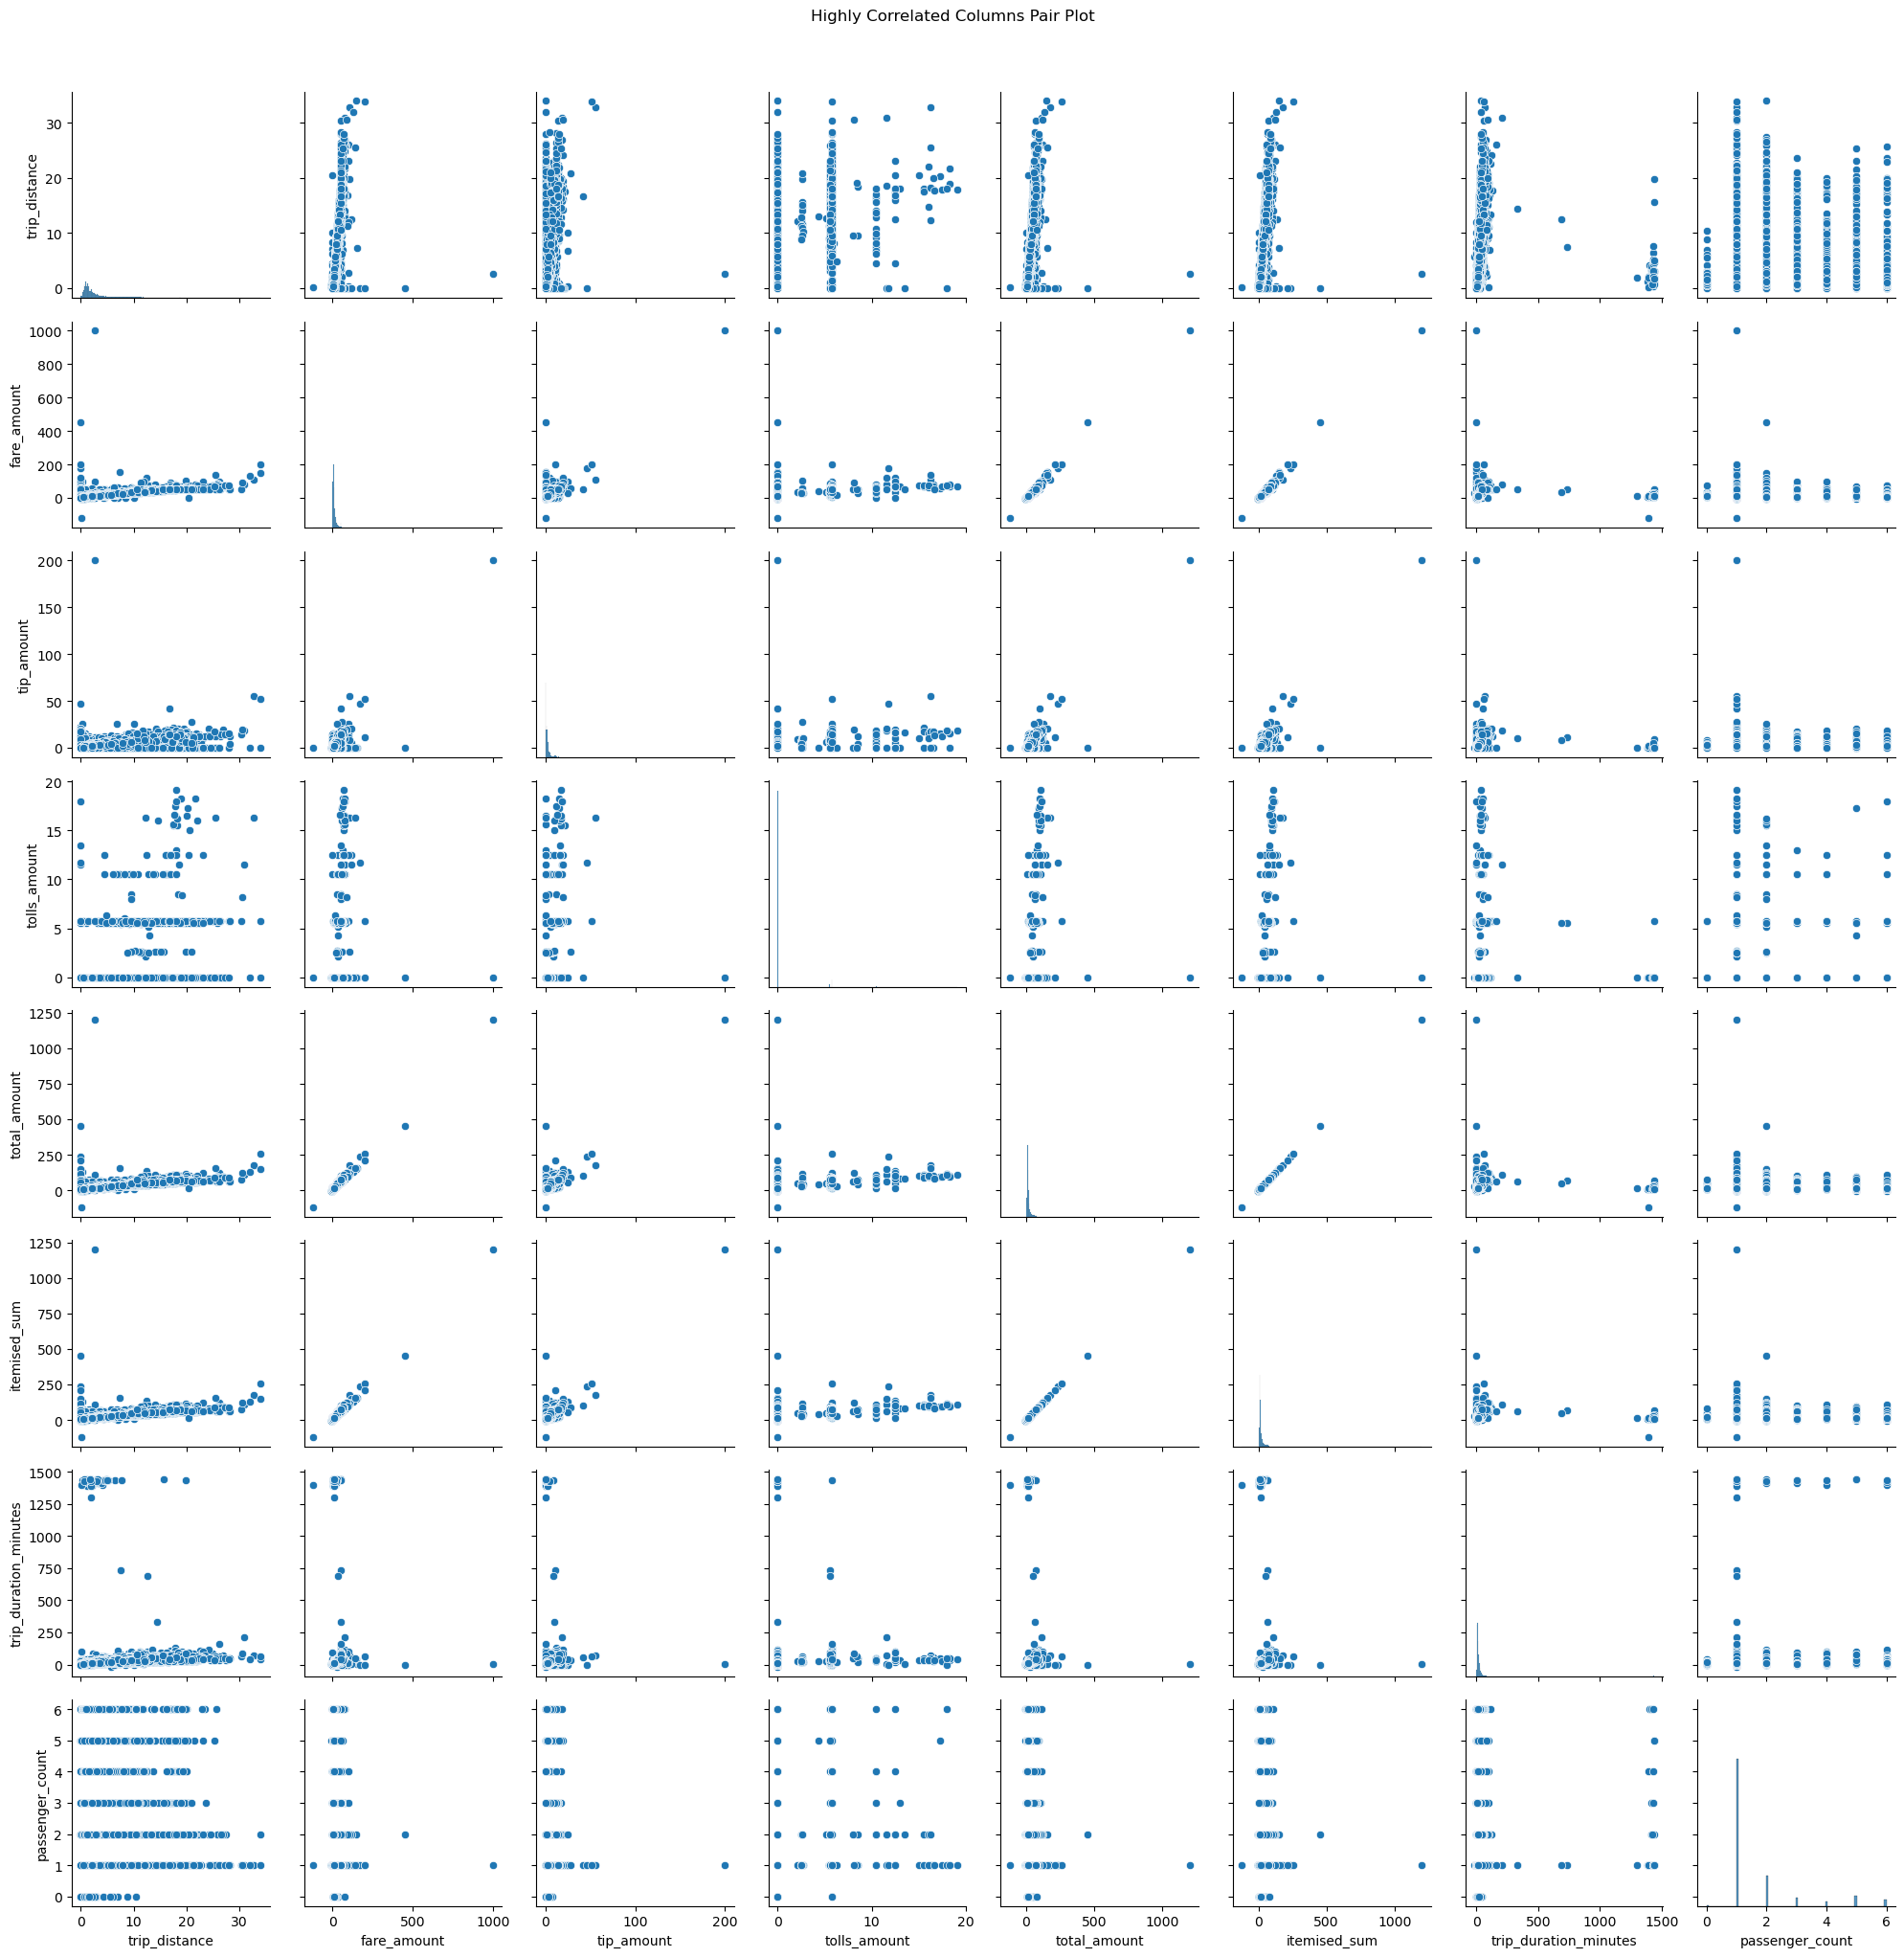

In [23]:
pairplot = sns.pairplot(df, vars=cols_for_visual,
            #hue='County'
            );
pairplot.fig.suptitle("Highly Correlated Columns Pair Plot", y=1.02) # y is used to adjust the position of the title
plt.tight_layout()
plt.show()

#### Tip distribution by vendor


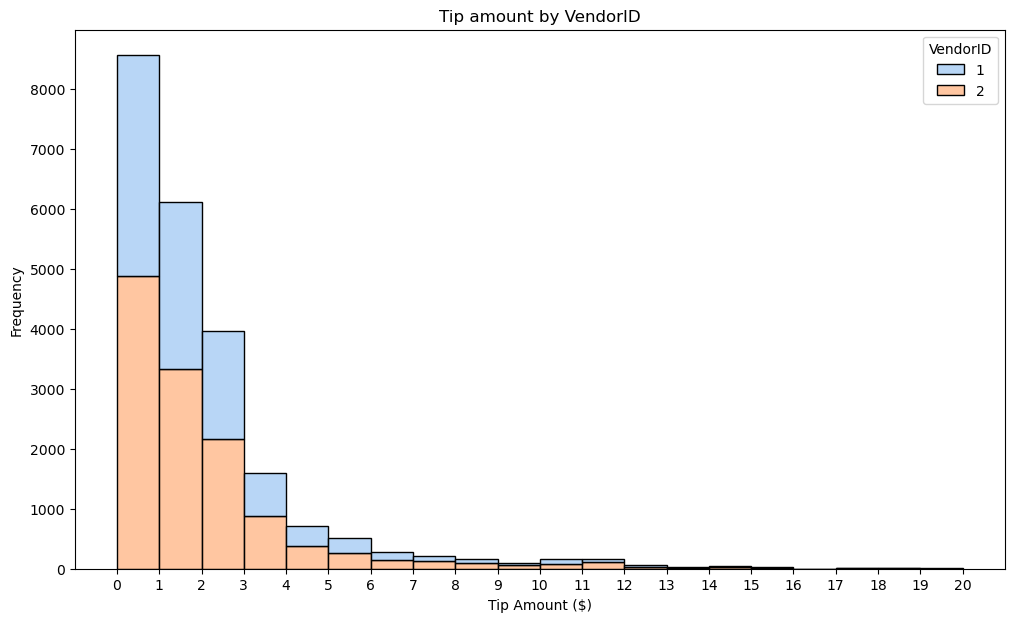

In [24]:
plt.figure(figsize=(12, 7))
ax = sns.histplot(data=df, x='tip_amount', bins=(range(0,21,1)),
                 hue='VendorID',
                 multiple='stack',
                 palette='pastel')
ax.set_xticks(range(0,21,1))
ax.set_xticklabels(range(0,21,1))
ax.set_xlabel('Tip Amount ($)')
ax.set_ylabel('Frequency')
plt.title('Tip amount by VendorID')
plt.show();

Splitting `tip_amount` by vendor shows broadly similar shapes, suggesting no obvious vendor-specific recording bias in the main range of tips.


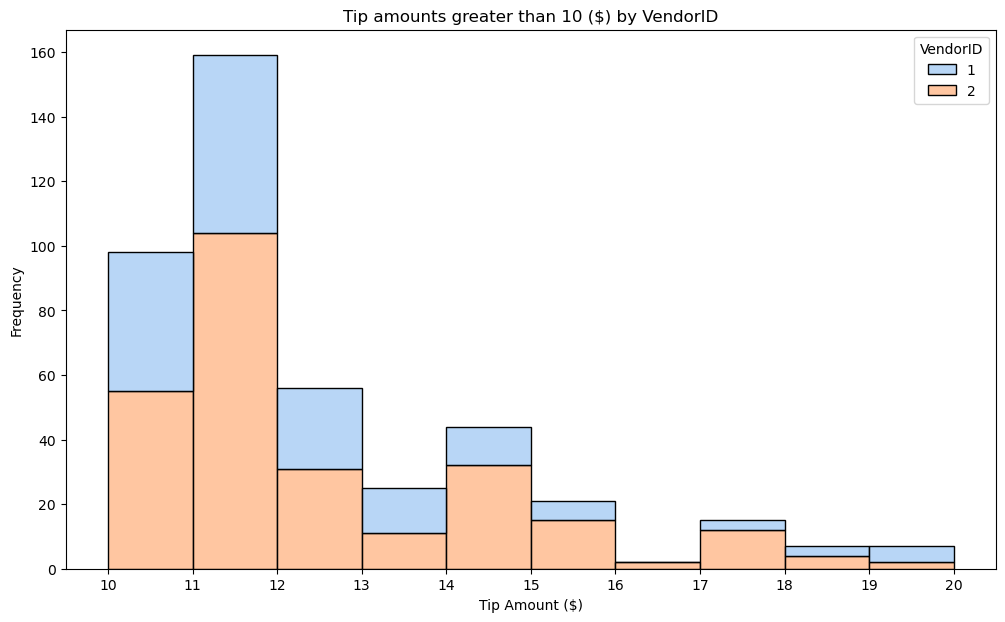

In [25]:
# Create histogram of tip_amount by vendor for tips > $10 
data = df[df['tip_amount'] > 10]
plt.figure(figsize=(12, 7))
ax = sns.histplot(data=data, x='tip_amount', bins=(range(10,21,1)),
                 hue='VendorID',
                 multiple='stack',
                 palette='pastel')
ax.set_xticks(range(10,21,1))
ax.set_xticklabels(range(10,21,1))
ax.set_xlabel('Tip Amount ($)')
ax.set_ylabel('Frequency')
plt.title('Tip amounts greater than 10 ($) by VendorID')
plt.show();

At very high tips the sample size drops, so differences in the far tail are noisy and not something to over-interpret.


#### Mean tips by passenger count

In [26]:
df.groupby('passenger_count')['tip_amount'].mean().reset_index().sort_values(by='tip_amount', ascending=False)

,passenger_count,tip_amount
0,0,2.14
5,5,1.87
2,2,1.86
1,1,1.85
6,6,1.72
3,3,1.72
4,4,1.53


In [27]:
mean_tips_by_passenger_count = df.groupby('passenger_count')['tip_amount'].mean().reset_index()

In [28]:
mean_tips_by_passenger_count

,passenger_count,tip_amount
0,0,2.14
1,1,1.85
2,2,1.86
3,3,1.72
4,4,1.53
5,5,1.87
6,6,1.72


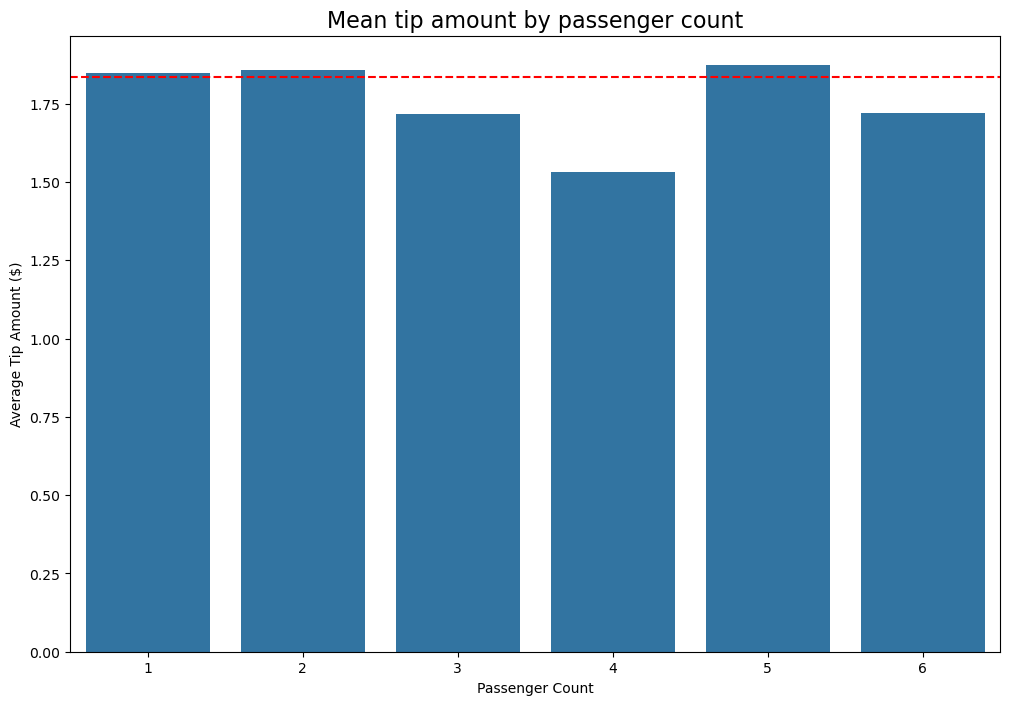

In [29]:

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=mean_tips_by_passenger_count[mean_tips_by_passenger_count['passenger_count'] > 0], 
                 x='passenger_count',
                 y= 'tip_amount',)
ax.set_xlabel('Passenger Count')
ax.set_ylabel('Average Tip Amount ($)')
ax.axhline(df['tip_amount'].mean(), ls='--', color='red', label='global mean')
plt.title('Mean tip amount by passenger count', fontsize=16);
plt.show();

**Note:** mean `tip_amount` varies only slightly by passenger count in this sample. Treat `passenger_count = 0` with caution, as it can be a data-entry artefact.


### Total revenue by day of week


In [30]:
total_amount_day = df.groupby('day')['total_amount'].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
total_amount_day = total_amount_day.reindex(index=day_order)

In [31]:
#make it dataframe for visualization
total_amount_day = pd.DataFrame(total_amount_day).reset_index()

In [32]:
total_amount_day

,day,total_amount
0,Monday,49574.37
1,Tuesday,52527.14
2,Wednesday,55310.47
3,Thursday,57181.91
4,Friday,55818.74
5,Saturday,51195.40
6,Sunday,48624.06


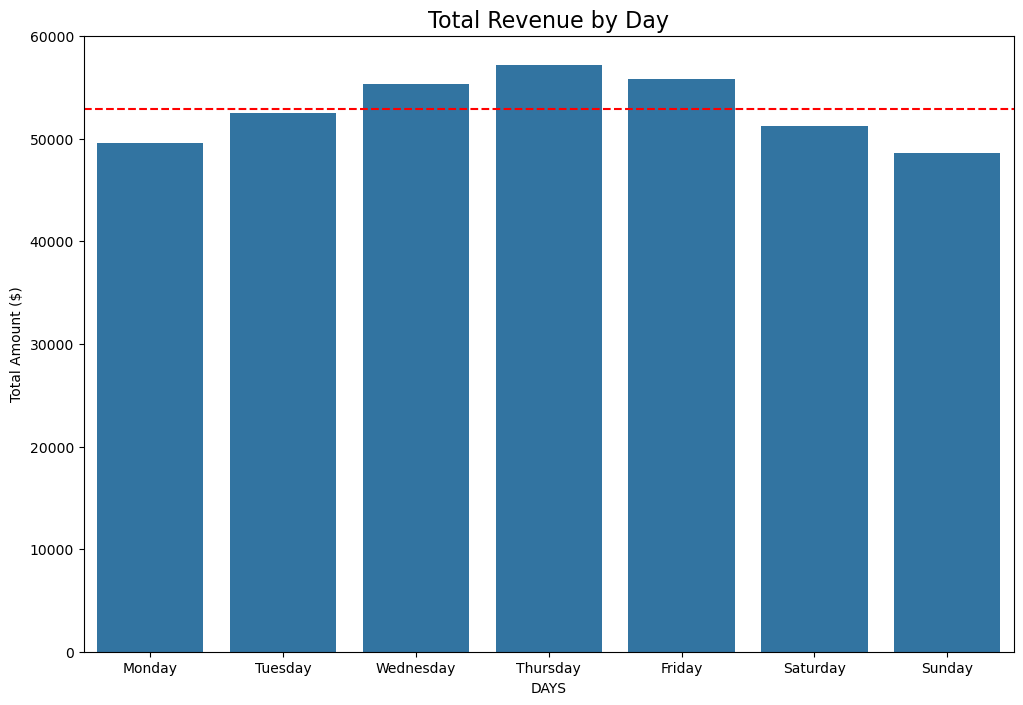

In [33]:
#Plot the revenue by day of the week
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=total_amount_day, 
                 x='day',
                 y= 'total_amount')
ax.set_xlabel('DAYS')
ax.set_ylabel('Total Amount ($)')
ax.axhline(total_amount_day['total_amount'].mean(), ls='--', color='red', label='global mean')
plt.title('Total Revenue by Day', fontsize=16);
plt.show();

In this sample, Thursday shows the highest gross revenue, while Sunday and Monday are the lowest. The gap is material (on the order of ~10% between the top and bottom days in this extract).


### Total revenue by month


In [34]:
total_amount_mount = df.groupby('month')['total_amount'].sum()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']
total_amount_mount = total_amount_mount.reindex(index=month_order)


#make it dataframe for visualization
total_amount_mount = pd.DataFrame(total_amount_mount).reset_index()

total_amount_mount.head()

,month,total_amount
0,January,31735.25
1,February,28937.89
2,March,33085.89
3,April,32012.54
4,May,33828.58


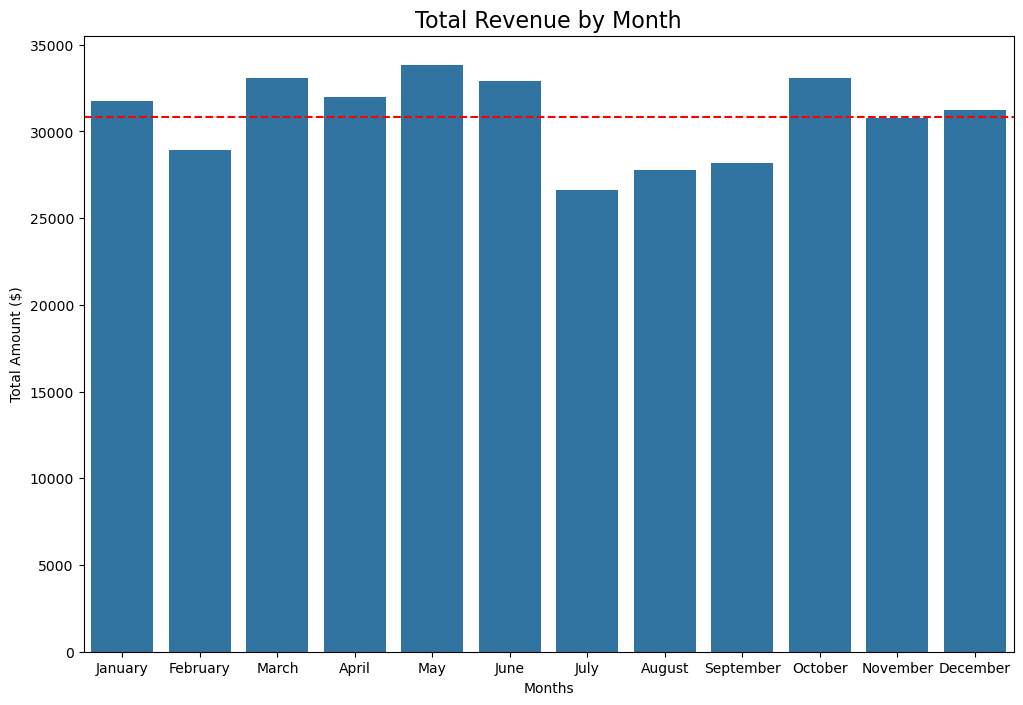

In [35]:
#Plot the revenue by day of the month
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=total_amount_mount, 
                 x='month',
                 y= 'total_amount')
ax.set_xlabel('Months')
ax.set_ylabel('Total Amount ($)')
ax.axhline(total_amount_mount['total_amount'].mean(), ls='--', color='red', label='global mean')
plt.title('Total Revenue by Month', fontsize=16);
plt.show();

Monthly revenue is fairly steady, with May as the peak month in this sample and lower totals in February and late summer.


### Mean trip distance by drop-off location


In [36]:
mean_trips_by_dropoff = df.groupby('DOLocationID')['trip_distance'].mean()
#make it dataframe for visualization
mean_trips_by_dropoff = pd.DataFrame(mean_trips_by_dropoff).reset_index().sort_values(by='trip_distance')

In [37]:
df['DOLocationID'].nunique()

216

In [38]:
mean_trips_by_dropoff['DOLocationID'].describe()

count   216.00
mean    134.44
std      76.88
min       1.00
25%      67.75
50%     135.50
75%     201.25
max     265.00
Name: DOLocationID, dtype: float64

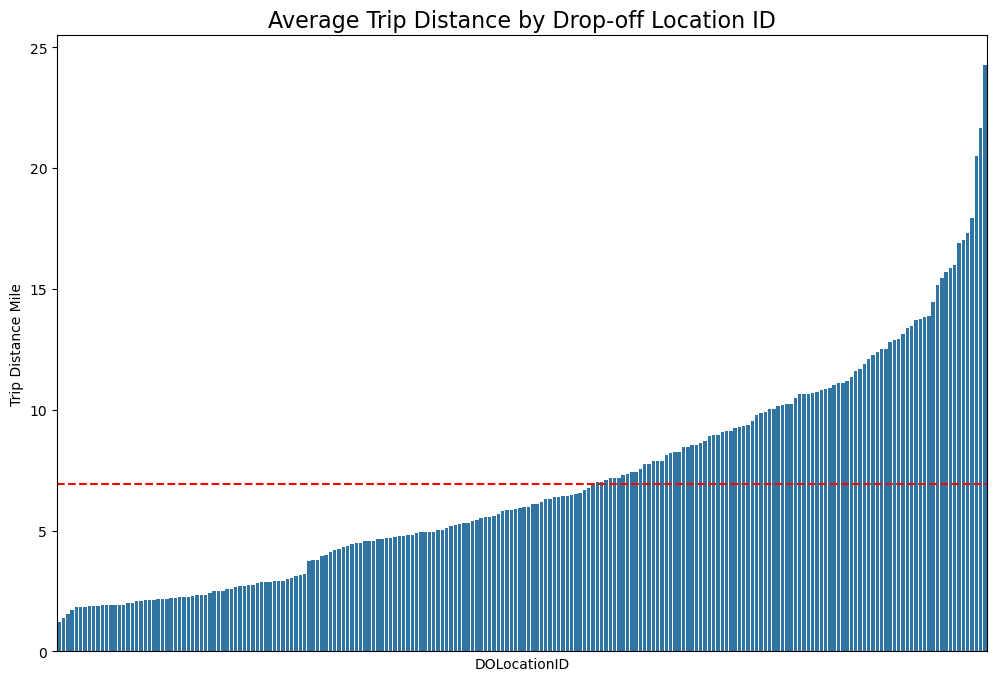

In [39]:
#Plot the revenue by day of the month
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=mean_trips_by_dropoff, 
                 x='DOLocationID',
                 y= 'trip_distance',
                order=mean_trips_by_dropoff['DOLocationID'])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylabel('Trip Distance Mile')
ax.axhline(mean_trips_by_dropoff['trip_distance'].mean(), ls='--', color='red', label='global mean')
plt.title('Average Trip Distance by Drop-off Location ID', fontsize=16);
plt.show();

The mean distance varies widely across drop-off locations. A small number of locations account for disproportionately long (and likely higher-value) trips, which is consistent with airport and long-distance travel patterns.


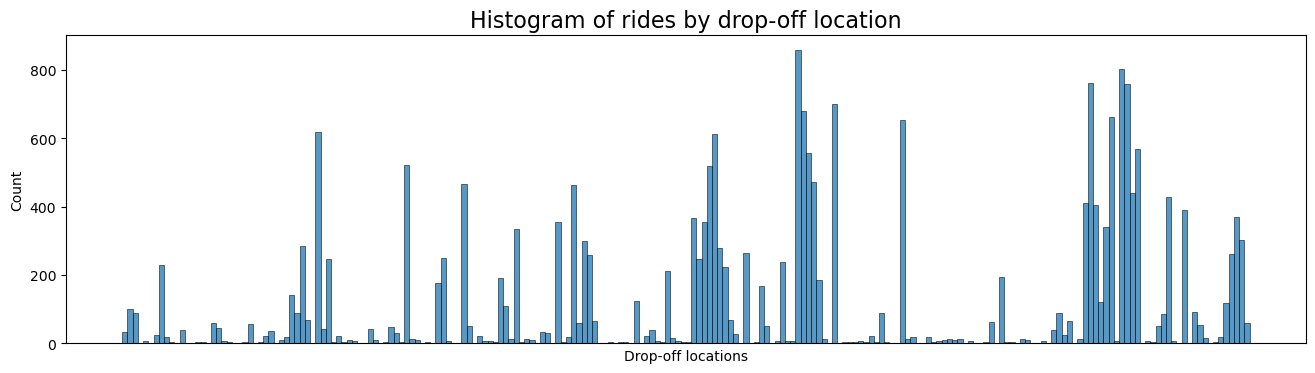

In [40]:
plt.figure(figsize=(16,4))
# DOLocationID column is numeric, so sort in ascending order
sorted_dropoffs = df['DOLocationID'].sort_values()
# Convert to string
sorted_dropoffs = sorted_dropoffs.astype('str')
# Plot
sns.histplot(sorted_dropoffs, bins=range(0, df['DOLocationID'].max()+1, 1))
plt.xticks([])
plt.xlabel('Drop-off locations')
plt.title('Histogram of rides by drop-off location', fontsize=16);

A practical next step for stakeholder-facing analysis is to join the TLC taxi zone lookup so these location IDs can be shown as readable zone/borough names (rather than numeric codes).


# Revenue drivers & anomaly monitoring (by day / time / zone)

This final section reframes the EDA into a practical analytics task: **monitor gross passenger charges** and identify when/where patterns change.

- **Revenue metric:** `total_amount` (total charged to the passenger; cash tips are not included in TLC extracts).
- We keep `fare_amount` and `tip_amount` to help explain *what* is driving changes in value across time and zones.


In [41]:
# --- Setup: create an analysis copy so we don't mutate earlier cells' results ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_ana = df.copy()

# Ensure datetimes exist and are parsed correctly (idempotent)
df_ana['tpep_pickup_datetime'] = pd.to_datetime(df_ana['tpep_pickup_datetime'], errors='coerce')
df_ana['tpep_dropoff_datetime'] = pd.to_datetime(df_ana['tpep_dropoff_datetime'], errors='coerce')

# Core time features
df_ana['pickup_date'] = df_ana['tpep_pickup_datetime'].dt.date
df_ana['pickup_hour'] = df_ana['tpep_pickup_datetime'].dt.hour
df_ana['pickup_dow'] = df_ana['tpep_pickup_datetime'].dt.day_name()
df_ana['pickup_week'] = df_ana['tpep_pickup_datetime'].dt.isocalendar().week.astype('int64')

# Trip duration (minutes). Keep only sensible durations.
df_ana['trip_duration_min'] = (df_ana['tpep_dropoff_datetime'] - df_ana['tpep_pickup_datetime']).dt.total_seconds() / 60

# Revenue components
df_ana['gross_revenue'] = df_ana['total_amount']  # passenger total (cash tips excluded)
df_ana['fare_revenue'] = df_ana['fare_amount']
df_ana['card_tip'] = df_ana['tip_amount']

# Basic validity filters for this section (do NOT delete rows globally; just filter for KPI computation)
valid_mask = (
    df_ana['tpep_pickup_datetime'].notna() &
    df_ana['tpep_dropoff_datetime'].notna() &
    df_ana['gross_revenue'].ge(0) &
    df_ana['fare_revenue'].ge(0) &
    df_ana['trip_distance'].ge(0) &
    df_ana['trip_duration_min'].between(1, 240, inclusive='both')  # 1 min to 4 hours (broad, avoids obvious bad records)
)
df_kpi = df_ana.loc[valid_mask].copy()

df_kpi.shape, df_ana.shape


((22429, 32), (22699, 32))

## KPI layer: daily, hourly and zone aggregates

We’ll compute a small set of KPIs that explain revenue as:

- **Total revenue** = sum of `gross_revenue`
- **Trips** = count of rows
- **Average revenue per trip** = revenue / trips
- Supporting context: average distance and duration


In [42]:
def build_kpi_table(g: pd.core.groupby.generic.DataFrameGroupBy) -> pd.DataFrame:
    return g.agg(
        trips=('gross_revenue', 'size'),
        revenue=('gross_revenue', 'sum'),
        avg_rev=('gross_revenue', 'mean'),
        avg_fare=('fare_revenue', 'mean'),
        avg_tip=('card_tip', 'mean'),
        avg_dist=('trip_distance', 'mean'),
        avg_dur_min=('trip_duration_min', 'mean'),
    ).sort_values('revenue', ascending=False)

daily_kpi = build_kpi_table(df_kpi.groupby('pickup_date'))
hourly_kpi = build_kpi_table(df_kpi.groupby('pickup_hour'))
dow_kpi = build_kpi_table(df_kpi.groupby('pickup_dow'))
zone_kpi = build_kpi_table(df_kpi.groupby('PULocationID'))

daily_kpi.head()


,trips,revenue,avg_rev,avg_fare,avg_tip,avg_dist,avg_dur_min
pickup_date,,,,,,,
2017-03-17,87,1881.90,21.63,17.26,2.56,3.87,19.90
2017-08-03,84,1476.41,17.58,14.56,1.64,3.33,17.18
2017-05-07,76,1474.54,19.40,15.70,2.44,4.04,16.77
2017-10-26,71,1450.20,20.43,16.08,2.37,3.90,20.07
2017-12-07,72,1446.11,20.08,15.91,2.36,3.52,19.92


In [43]:
# Quick sanity-check: does revenue = trips * avg_rev?
check = (daily_kpi['trips'] * daily_kpi['avg_rev']).sub(daily_kpi['revenue']).abs().max()
check


2.2737367544323206e-13

## Revenue drivers: when does revenue happen?

### 1) By hour of day  
This identifies demand peaks (volume) and value peaks (avg revenue per trip).


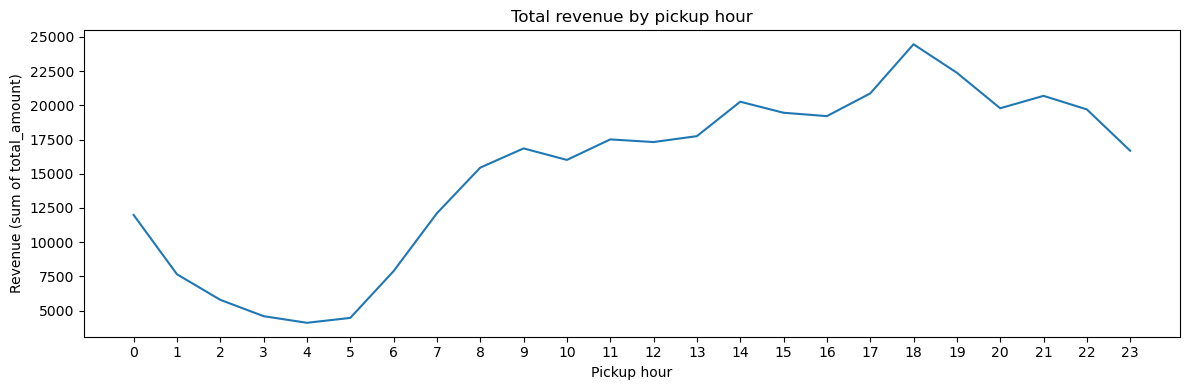

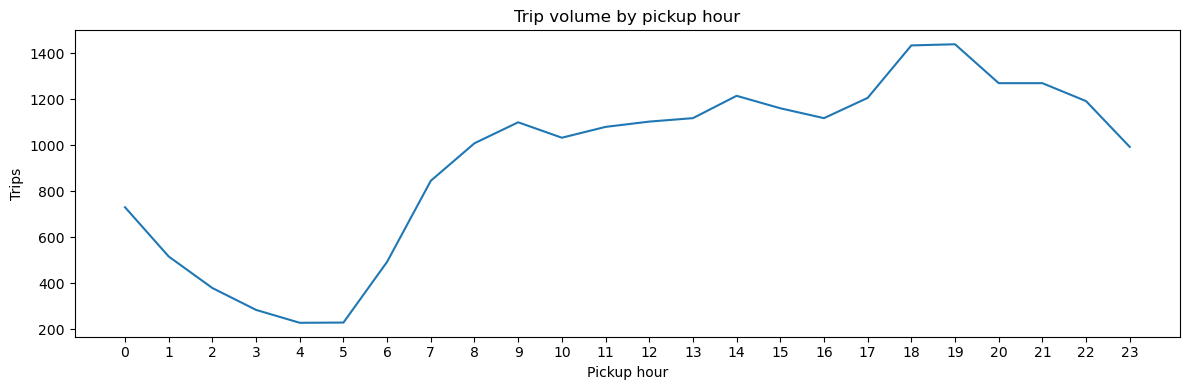

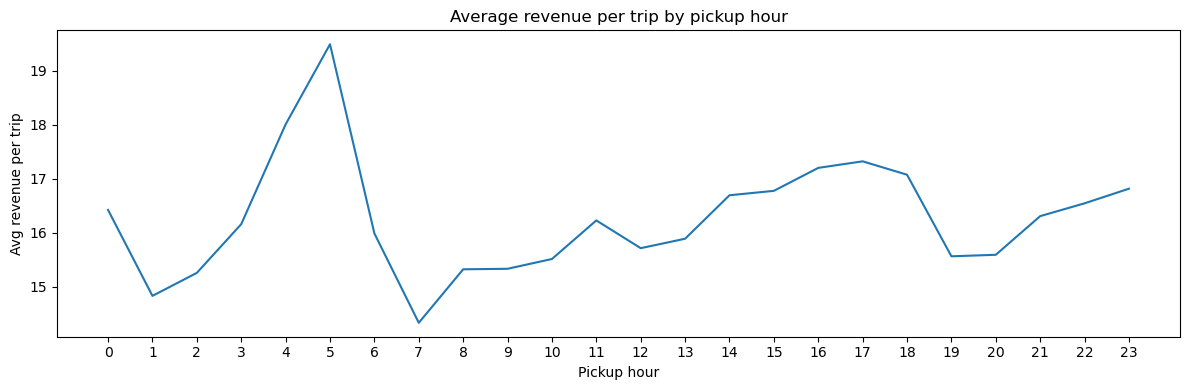

In [44]:
# Hourly patterns
hourly_sorted = hourly_kpi.sort_index()

plt.figure(figsize=(12, 4))
plt.plot(hourly_sorted.index, hourly_sorted['revenue'])
plt.title("Total revenue by pickup hour")
plt.xlabel("Pickup hour")
plt.ylabel("Revenue (sum of total_amount)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(hourly_sorted.index, hourly_sorted['trips'])
plt.title("Trip volume by pickup hour")
plt.xlabel("Pickup hour")
plt.ylabel("Trips")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(hourly_sorted.index, hourly_sorted['avg_rev'])
plt.title("Average revenue per trip by pickup hour")
plt.xlabel("Pickup hour")
plt.ylabel("Avg revenue per trip")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


### 2) By day of week  
Helps spot weekday vs weekend effects.


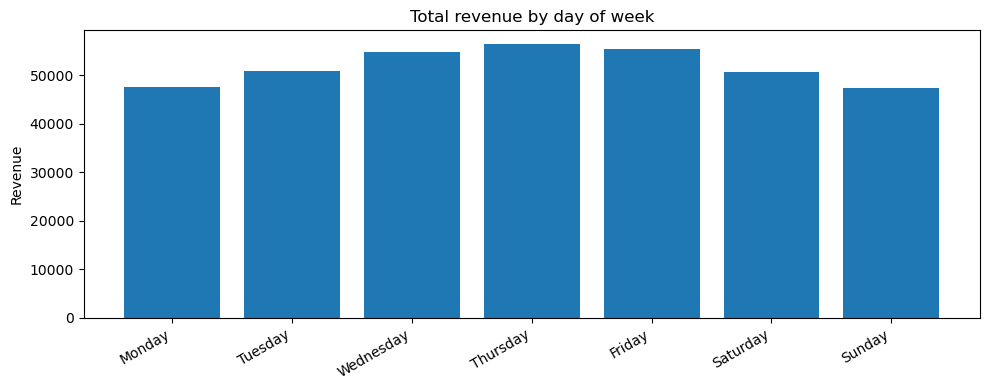

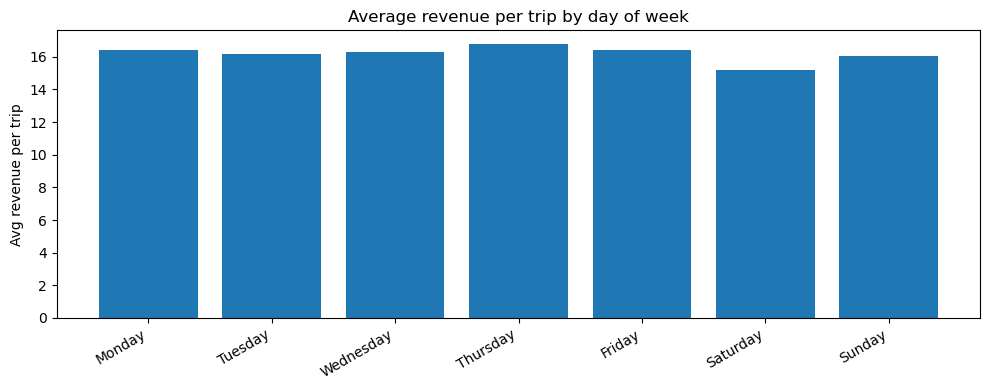

In [45]:
# Order days properly
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_sorted = dow_kpi.reindex(dow_order)

plt.figure(figsize=(10, 4))
plt.bar(dow_sorted.index, dow_sorted['revenue'])
plt.title("Total revenue by day of week")
plt.ylabel("Revenue")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(dow_sorted.index, dow_sorted['avg_rev'])
plt.title("Average revenue per trip by day of week")
plt.ylabel("Avg revenue per trip")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


### 3) By pickup zone (PULocationID)  
Most taxi revenue is concentrated in a small number of pickup zones. We’ll quantify that concentration, and list the “top zones”.


In [46]:
# Concentration: how much revenue comes from the top N pickup zones?
zone_sorted = zone_kpi.copy()
zone_sorted['rev_share'] = zone_sorted['revenue'] / zone_sorted['revenue'].sum()
zone_sorted['rev_share_cum'] = zone_sorted['rev_share'].cumsum()

top_n = 15
zone_top = zone_sorted.head(top_n)

zone_top[['trips','revenue','avg_rev','rev_share','rev_share_cum']]


,trips,revenue,avg_rev,rev_share,rev_share_cum
PULocationID,,,,,
132,508,28339.98,55.79,0.08,0.08
138,620,26928.72,43.43,0.07,0.15
161,852,12621.90,14.81,0.03,0.19
186,785,11572.79,14.74,0.03,0.22
162,766,11179.44,14.59,0.03,0.25
170,742,11004.54,14.83,0.03,0.28
237,885,10979.69,12.41,0.03,0.31
230,728,10972.48,15.07,0.03,0.34
48,738,10552.77,14.30,0.03,0.37


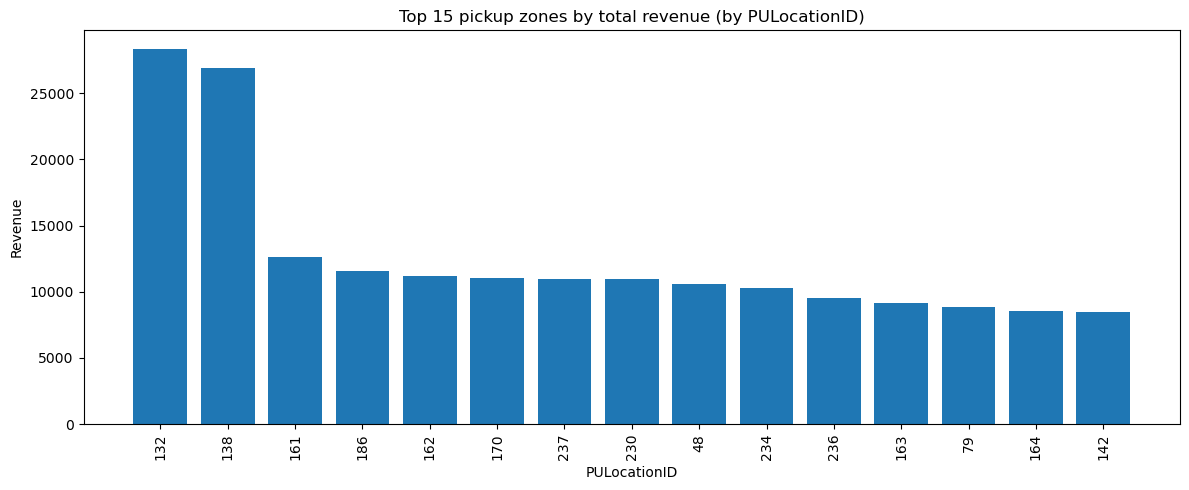

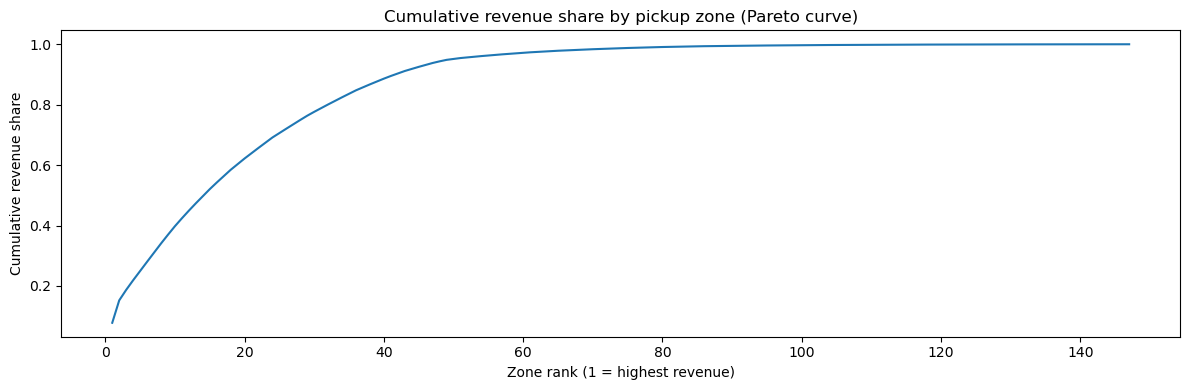

In [47]:
plt.figure(figsize=(12, 5))
plt.bar(zone_top.index.astype(str), zone_top['revenue'])
plt.title(f"Top {top_n} pickup zones by total revenue (by PULocationID)")
plt.xlabel("PULocationID")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(zone_sorted)+1), zone_sorted['rev_share_cum'].to_numpy())
plt.title("Cumulative revenue share by pickup zone (Pareto curve)")
plt.xlabel("Zone rank (1 = highest revenue)")
plt.ylabel("Cumulative revenue share")
plt.tight_layout()
plt.show()


## What explains higher-value trips?

Two quick lenses that often explain changes in *average revenue per trip*:
- **Payment type mix** (credit vs cash vs dispute/no-charge)
- **Trip distance and duration** (longer trips generally cost more)


In [48]:
# Payment type mapping (TLC standard encoding)
payment_type_map = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip",
}
df_kpi['payment_type_label'] = df_kpi['payment_type'].map(payment_type_map).fillna("Other/NA")

pay_kpi = build_kpi_table(df_kpi.groupby('payment_type_label'))

pay_kpi


,trips,revenue,avg_rev,avg_fare,avg_tip,avg_dist,avg_dur_min
payment_type_label,,,,,,,
Credit card,15163,264267.81,17.43,13.24,2.70,3.05,14.79
Cash,7148,96695.44,13.53,12.19,0.00,2.68,13.75
No charge,83,1420.93,17.12,15.41,0.00,3.91,16.54
Dispute,35,635.86,18.17,16.29,0.00,4.18,17.88


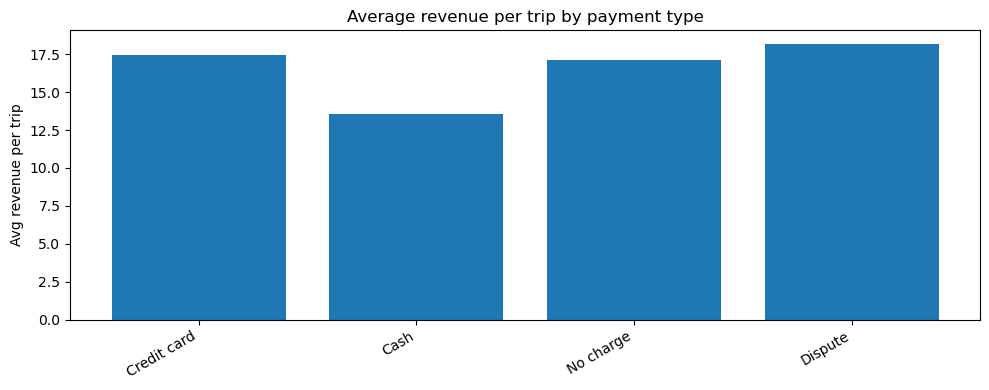

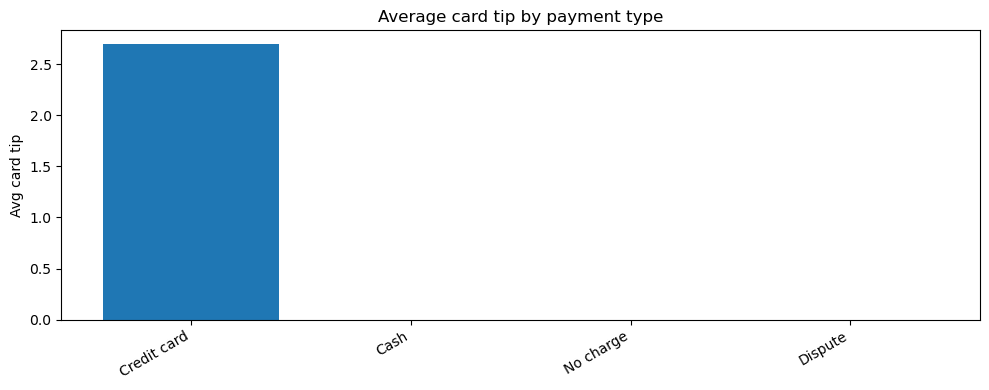

In [49]:
plt.figure(figsize=(10, 4))
plt.bar(pay_kpi.index, pay_kpi['avg_rev'])
plt.title("Average revenue per trip by payment type")
plt.ylabel("Avg revenue per trip")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(pay_kpi.index, pay_kpi['avg_tip'])
plt.title("Average card tip by payment type")
plt.ylabel("Avg card tip")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [50]:
# Relationship between distance/duration and revenue (simple, interpretable)
# (Keep it light: just correlations on valid records)
corr_cols = ['gross_revenue', 'fare_revenue', 'card_tip', 'trip_distance', 'trip_duration_min', 'passenger_count']
corr = df_kpi[corr_cols].corr(numeric_only=True)

corr


,gross_revenue,fare_revenue,card_tip,trip_distance,trip_duration_min,passenger_count
gross_revenue,1.00,0.98,0.72,0.94,0.85,0.01
fare_revenue,0.98,1.00,0.60,0.94,0.87,0.02
card_tip,0.72,0.60,1.00,0.59,0.52,-0.01
trip_distance,0.94,0.94,0.59,1.00,0.79,0.02
trip_duration_min,0.85,0.87,0.52,0.79,1.00,0.01
passenger_count,0.01,0.02,-0.01,0.02,0.01,1.00


## Anomaly detection: flag unusual days (revenue and trips)

We’ll use a robust rolling baseline:
- Rolling **median** as the expected value
- Rolling **MAD** (median absolute deviation) to scale deviations
- Flag days where the robust z-score is large (e.g., |z| ≥ 3.5)

This is deliberately lightweight (appropriate for an analyst project), but still defensible.


In [51]:
daily_ts = daily_kpi.sort_index().copy()

# Convert index to datetime for rolling operations
daily_ts.index = pd.to_datetime(daily_ts.index)

def robust_zscore(series: pd.Series, window: int = 14) -> pd.Series:
    med = series.rolling(window=window, min_periods=max(3, window//3)).median()
    mad = (series - med).abs().rolling(window=window, min_periods=max(3, window//3)).median()
    # Avoid division by zero: where MAD==0, zscore is 0 (no variation)
    z = 0.6745 * (series - med) / mad.replace(0, np.nan)
    return z.fillna(0)

daily_ts['rev_z'] = robust_zscore(daily_ts['revenue'], window=14)
daily_ts['trips_z'] = robust_zscore(daily_ts['trips'], window=14)

# Flag anomalies
z_th = 3.5
anoms = daily_ts[(daily_ts['rev_z'].abs() >= z_th) | (daily_ts['trips_z'].abs() >= z_th)].copy()

anoms[['trips','revenue','avg_rev','rev_z','trips_z']].sort_values(['rev_z','trips_z'], ascending=False).head(10)


,trips,revenue,avg_rev,rev_z,trips_z
pickup_date,,,,,
2017-03-17,87,1881.90,21.63,5.59,1.90
2017-08-03,84,1476.41,17.58,4.02,2.86
2017-02-03,74,1306.82,17.66,3.89,2.25
2017-01-21,87,1373.58,15.79,3.76,7.76
2017-02-01,74,1281.22,17.31,3.62,2.70
2017-03-04,89,1234.02,13.87,1.44,4.55
2017-02-25,81,1214.69,15.00,1.37,3.57
2017-11-23,34,512.92,15.09,-2.27,-3.78
2017-02-09,39,496.44,12.73,-2.86,-3.96


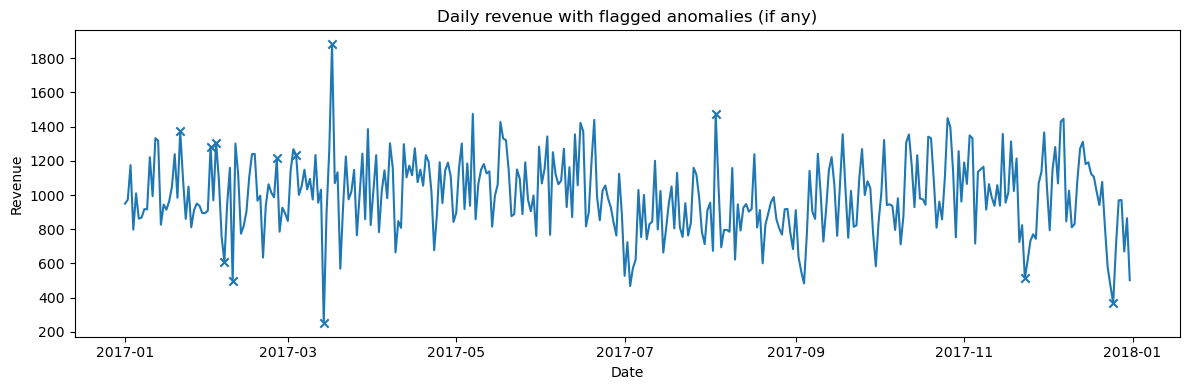

In [52]:
plt.figure(figsize=(12, 4))
plt.plot(daily_ts.index, daily_ts['revenue'])
plt.title("Daily revenue with flagged anomalies (if any)")
plt.xlabel("Date")
plt.ylabel("Revenue")

if not anoms.empty:
    plt.scatter(anoms.index, anoms['revenue'], marker='x')

plt.tight_layout()
plt.show()


### Drill-down for an anomaly date (if present)

For the most extreme anomaly (by revenue z-score), we’ll compare:
- Revenue by hour on that date vs typical hour pattern (median across all dates)
- Revenue by pickup zone on that date vs typical zone pattern (median across all dates)

If no anomalies are found (common with small samples), we still show the drill-down logic on the single highest-revenue day.


In [53]:
if anoms.empty:
    # Fallback: take the highest-revenue date as the "interesting day" for drill-down
    focus_date = daily_ts['revenue'].idxmax().date()
    focus_reason = "No anomalies found under the threshold; using the highest-revenue day instead."
else:
    focus_date = anoms['rev_z'].abs().idxmax().date()
    focus_reason = "Using the most extreme revenue anomaly (highest |z|)."

focus_date, focus_reason


(datetime.date(2017, 3, 17),
 'Using the most extreme revenue anomaly (highest |z|).')

In [54]:
focus_mask = (df_kpi['pickup_date'] == focus_date)

# Hour-of-day comparison
hour_focus = build_kpi_table(df_kpi.loc[focus_mask].groupby('pickup_hour')).sort_index()
hour_typical = build_kpi_table(df_kpi.groupby('pickup_hour')).sort_index()

hour_compare = pd.DataFrame({
    'focus_revenue': hour_focus['revenue'],
    'typical_revenue': hour_typical['revenue'],
    'focus_trips': hour_focus['trips'],
    'typical_trips': hour_typical['trips'],
}).fillna(0)

hour_compare.head()


,focus_revenue,typical_revenue,focus_trips,typical_trips
pickup_hour,,,,
0,168.95,11989.09,6.00,730
1,0.00,7654.55,0.00,516
2,0.00,5783.54,0.00,379
3,0.00,4589.62,0.00,284
4,0.00,4105.37,0.00,228


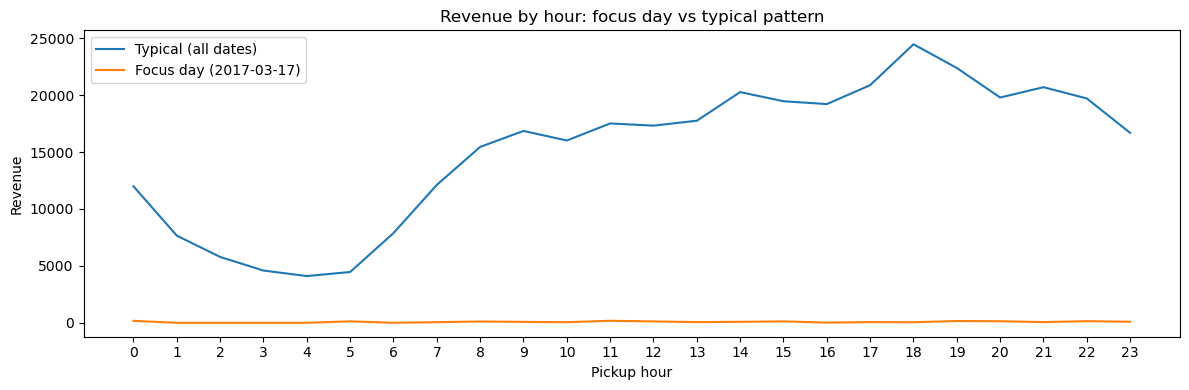

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(hour_compare.index, hour_compare['typical_revenue'], label='Typical (all dates)')
plt.plot(hour_compare.index, hour_compare['focus_revenue'], label=f'Focus day ({focus_date})')
plt.title("Revenue by hour: focus day vs typical pattern")
plt.xlabel("Pickup hour")
plt.ylabel("Revenue")
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
# Zone comparison: which pickup zones drove the focus day?
zone_focus = build_kpi_table(df_kpi.loc[focus_mask].groupby('PULocationID'))
zone_typical = build_kpi_table(df_kpi.groupby('PULocationID'))

zone_compare = zone_focus[['revenue','trips']].join(
    zone_typical[['revenue','trips']].rename(columns={'revenue':'typical_revenue','trips':'typical_trips'}),
    how='left'
).fillna(0)

zone_compare['revenue_lift'] = zone_compare['revenue'] - zone_compare['typical_revenue'] * (zone_compare['revenue'].sum() / zone_typical['revenue'].sum())
zone_compare = zone_compare.sort_values('revenue_lift', ascending=False)

zone_compare.head(10)


,revenue,trips,typical_revenue,typical_trips,revenue_lift
PULocationID,,,,,
141,114.96,4,6208.27,485,82.78
233,102.80,1,4476.29,274,79.59
138,201.86,4,26928.72,620,62.26
88,59.15,2,1777.69,89,49.93
170,96.21,8,11004.54,742,39.16
229,65.51,3,6303.19,435,32.83
249,67.26,3,6772.86,478,32.15
152,32.05,2,173.58,12,31.15
161,95.01,3,12621.90,852,29.58


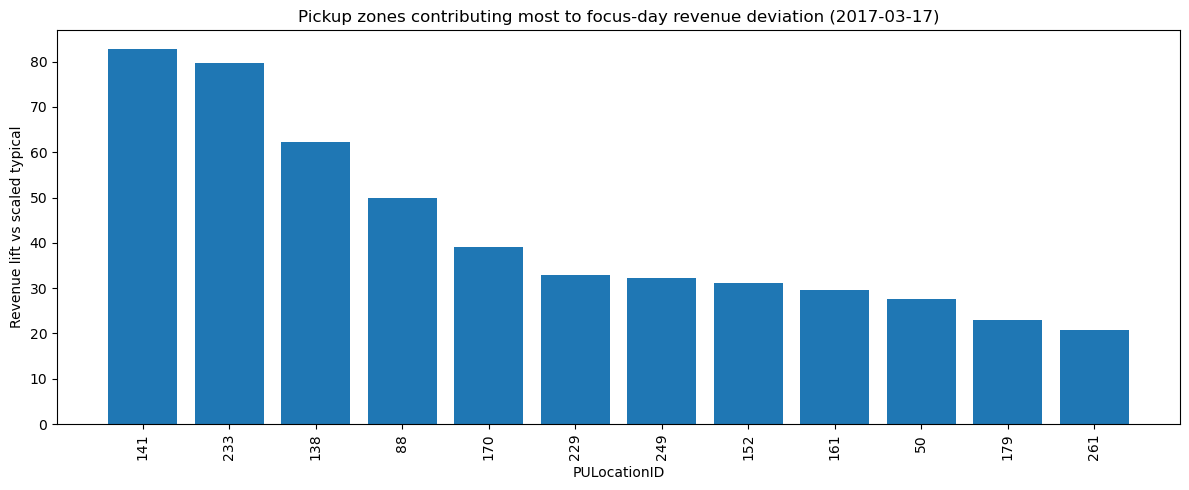

In [57]:
plt.figure(figsize=(12, 5))
top_drivers = zone_compare.head(12)
plt.bar(top_drivers.index.astype(str), top_drivers['revenue_lift'])
plt.title(f"Pickup zones contributing most to focus-day revenue deviation ({focus_date})")
plt.xlabel("PULocationID")
plt.ylabel("Revenue lift vs scaled typical")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Recommendations (based on the patterns above)

The exact numbers depend on the sample, but the logic is consistent and transferable to a full-year dataset:

1. **Staffing / supply alignment:** use the hourly pattern to bias driver supply towards the highest-volume windows, and use average revenue per trip to identify high-value hours (often airports, evening travel, or long-distance periods).
2. **Zone-focused positioning:** the Pareto curve typically shows that a small number of pickup zones drive a large share of revenue. Operationally, that suggests prioritising coverage and queue management in those zones.
3. **Monitoring & investigation:** the anomaly flags provide a lightweight early-warning system. When a revenue/trips anomaly appears, drill down by hour and pickup zone to quickly isolate whether the cause is:
   - a city-wide demand shock (weather/events),
   - a localised zone effect (closure/incident),
   - or a data quality issue (bad meter readings / missing fields).


## Conclusion

This project starts with classic EDA, then turns the findings into an analyst-friendly workflow:

- Validated monetary fields with an itemised reconciliation check
- Summarised demand and value patterns by **hour**, **day of week**, and **pickup zone**
- Added a simple anomaly flag to spot unusual days and guide investigation

The result is a notebook that demonstrates not just plotting, but decision-oriented analysis and a clear path from “pattern” → “investigate” → “action”.
